In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = 40,10
plt.rcParams["font.size"] = 15

In [4]:
from one.utils import *
from one.data.ucrdata import UcrDataReader

In [5]:
ROOT_DIR = "./data/ucr/"
t = get_files_from_path("./data/ucr")

In [8]:
d = UcrDataReader()
test = d(ROOT_DIR+t[26])

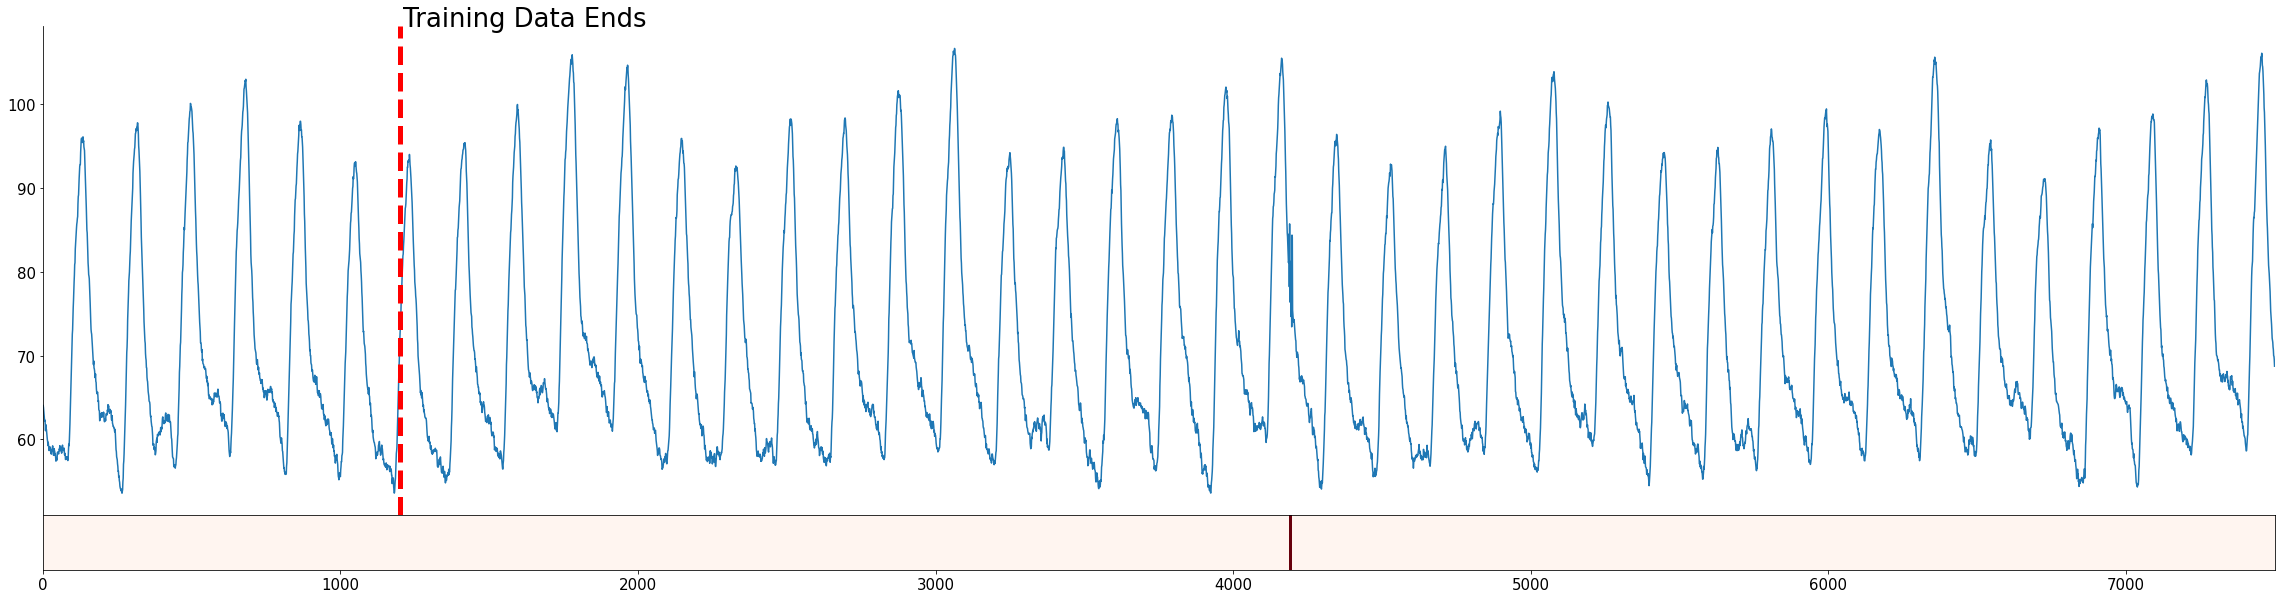

In [9]:
p = graph_data(test.series, test.labels, test.train_len)


In [12]:
test.series[:5]

array([63.748549, 64.0763  , 63.840841, 63.409148, 62.927837])